<a href="https://colab.research.google.com/github/ikonushok/AI-Traiding/blob/main/SBER_val_2019_Up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython.display import clear_output
from tensorflow.keras.models import load_model
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler # проверить все

In [ ]:
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import os, time
import warnings
warnings.filterwarnings("ignore")

In [ ]:
path_tickers = '/content/drive/MyDrive/_Диплом/Капитал-Инвест/ins_OHLC'
path_outputs_val = '/content/drive/MyDrive/_Диплом/Капитал-Инвест/SBER_MIN60/Up/txt'
path_models = '/content/drive/MyDrive/_Диплом/Капитал-Инвест/SBER_MIN60/Up/models'

os.chdir(path_tickers)
tickers_list = os.listdir()
print('Всего тикеров: ', len(tickers_list), '\n')
ticker = tickers_list[-1]
ticker

Всего тикеров:  21 



'SBER_MIN60.txt'

### Демонстрация работы кода

In [ ]:
os.chdir(path_models)
models_list = os.listdir()
print('Всего обученных моделей: ', len(models_list), '\n')
models_list = models_list
print(models_list)
#models_list = ['_SBER_Conv_1h_Up.h5', '_SBER_Dense_1h_Up.h5', '_SBER_LSTM_1h_Up.h5']

Всего обученных моделей:  9 

['152691_t14_e22_SBER_Conv_1h_Up_v1.h5', '153547_t14_e30_SBER_Conv_1h_Up_v1.h5', '145832_t14_e31_SBER_GRU_1h_Up_v1.h5', '150540_t14_e29_SBER_Conv_1h_Up_v1.h5', '152070_t14_e28_SBER_Conv_1h_Up_v1.h5', '149253_t14_e27_SBER_Dense_1h_Up_v1.h5', '151543_t14_e30_SBER_GRU_1h_Up_v1.h5', '151543_t14_e28_SBER_GRU_1h_Up_v1.h5', '151543_t14_e29_SBER_GRU_1h_Up_v1.h5']


In [ ]:
trend = int(models_list[0][8:10])      # step_in_the_last
ensemble = int(models_list[0][12:14])  # n_steps
#trend = 14
#ensemble = 19
trend, ensemble

(14, 22)

In [ ]:
# Загрузка только [Open, High, Low, Close]
os.chdir(path_tickers)
data = pd.read_csv(ticker, sep="\t", header=None)
print(ticker)
data.columns=['Date', 'Open', 'High', 'Low', 'Close']
data

SBER_MIN60.txt


,Date,Open,High,Low,Close
0,2000-01-05 11:00:00.000,1.15000,1.17000,1.0800,1.125
1,2000-01-05 12:00:00.000,1.13500,1.17300,1.1350,1.168
2,2000-01-05 13:00:00.000,1.16500,1.23999,1.1650,1.200
3,2000-01-05 14:00:00.000,1.20000,1.25500,1.1980,1.255
4,2000-01-05 15:00:00.000,1.23001,1.26488,1.2115,1.264
...,...,...,...,...,...
43128,2019-12-30 14:00:00.000,253.05000,255.25000,252.9700,255.210
43129,2019-12-30 15:00:00.000,255.20000,256.00000,254.8600,255.160
43130,2019-12-30 16:00:00.000,255.16000,255.94000,254.5300,255.620
43131,2019-12-30 17:00:00.000,255.62000,255.65000,254.5500,254.810


In [ ]:
# Расчет индекса старта с 1 января 2019 года
mask = (data['Date'] >= '2019-01-01 01:00:00.000') & (data['Date'] <= '2019-12-31 23:59:59.999') # ключевая строка для форвадного анализа
min(data[mask].index), max(data[mask].index)

(40865, 43132)

In [ ]:
# Загружаем датасет с учетом необходимости формировать ensemble
#mask = (data['Date'] >= '2019-01-01 01:00:00.000') & (data['Date'] <= '2019-12-31 23:59:59.999') # ключевая строка для форвадного анализа
#mask = (data['Date'] >= '2019-01-01 00:00:00.000') & (data['Date'] <= '2019-03-31 23:59:59.999')
data = data[ (min(data[mask].index) - ensemble) : max(data[mask].index) ]
data

,Date,Open,High,Low,Close
40843,2018-12-27 15:00:00.000,184.88,185.85,184.81,185.45
40844,2018-12-27 16:00:00.000,185.39,186.10,185.02,185.20
40845,2018-12-27 17:00:00.000,185.20,185.85,184.79,185.11
40846,2018-12-27 18:00:00.000,185.12,185.50,184.18,185.00
40847,2018-12-28 10:00:00.000,185.78,186.20,184.98,185.35
...,...,...,...,...,...
43127,2019-12-30 13:00:00.000,252.88,253.55,252.78,253.03
43128,2019-12-30 14:00:00.000,253.05,255.25,252.97,255.21
43129,2019-12-30 15:00:00.000,255.20,256.00,254.86,255.16
43130,2019-12-30 16:00:00.000,255.16,255.94,254.53,255.62


In [ ]:
#data = data[-500:] # взяли последние 500 баров, окторые откусили при обучении, чтобы их не видела нейронка
df_date = data['Date'] # Оставляем дату, чтобы потом добавить в outputs
df_date

40843    2018-12-27 15:00:00.000
40844    2018-12-27 16:00:00.000
40845    2018-12-27 17:00:00.000
40846    2018-12-27 18:00:00.000
40847    2018-12-28 10:00:00.000
                  ...           
43127    2019-12-30 13:00:00.000
43128    2019-12-30 14:00:00.000
43129    2019-12-30 15:00:00.000
43130    2019-12-30 16:00:00.000
43131    2019-12-30 17:00:00.000
Name: Date, Length: 2289, dtype: object

# Моделирование торговли
на данных 2019 года

## Необходимые функции

In [ ]:
"""
#### Функция разделения массива на выборки для обучения нейросети 
"""
# sequence = строка массива df
# trend = число баров в прошлом для анализа - необходимо найти оптимальный!!
# forvard_lag = предсказание какого бара в будущем делаем 

def split_sequence(sequence, ensemble, forvard_lag=0):
  # sequence = df.values - это массив из данных
  # trend = число баров в прошлом для анализа
  X = list()
  for i in range(len(sequence)):
    end_ix = i + ensemble # находим конечный индекс строки
    if end_ix + (forvard_lag-1) > len(sequence)-1: # cпроверем чтобы не выйти за пределы массива
      break 
    # получаем X и y
    seq_x = sequence[i:end_ix]
    X.append(seq_x)

  return array(X)

In [ ]:
def trading(model, xTest):
  x_test = xTest
  returns = pd.DataFrame()
  statement = 0 #  {0:in_cash, 1:long, 2:short}
  stock = 0.   # Число акций
  cash = 1000000.   # Стартовая сумма капитала
  # -----------------------------------------

  for i in range(len(x_test)):   # Выбираю пример
    x = x_test[i]
    x = np.expand_dims(x, axis=0)
    prediction = model.predict(x) # Распознаём наш пример  == {0:stay, 1:up, 2:down}
    signal = np.argmax(prediction) # Получаем индекс самого большого элемента (это итоговая цифра)
    #close = xScaler.inverse_transform(x_test[i])[-3][0] # опрелеяем текущую цену, подаваемую в нейронку
    close = xScaler.inverse_transform(x_test[i])
    #close = close[-1][3]
    close = close[-1][0]

    if statement == 0  and  signal == 1:## ok
      statement = 1
      capital = cash//close * close + cash - cash//close * close
      inv_capital = cash//close * close
      line = pd.DataFrame({'statement':[0], 'signal':[signal], 'close':[close],'stock':[cash//close], 'deal_prise':[close],
                           'long':[close*0.9], 'short':[0], 'inv_capital':[inv_capital], 'cash':[cash - cash//close * close],
                           'capital':[capital], 'ret(i)':[0] })
      #clear_output()
      returns = returns.append(line, ignore_index=True)
      #print(returns.shape)
      #print(returns[-5:])
      continue
  

    elif statement == 0  and  signal == 0:## ok
      line = pd.DataFrame({'statement':[statement], 'signal':[signal], 'close':[close],'stock':[0],  'deal_prise':[0],
                           'long':[0], 'short':[0], 'inv_capital':[0], 'cash':[cash], 'capital':[cash], 'ret(i)':[0] })
      #clear_output()
      returns = returns.append(line, ignore_index=True)
      #print(returns.shape)
      #print(returns[-5:])
      continue
      
      
    elif statement == 1  and  signal == 1:## ok
      stock = returns.iloc[i-1][3]
      cash = returns.iloc[i-1][8]
      inv_capital = close*stock
      capital = close*stock+cash
      line = pd.DataFrame({'statement':[statement], 'signal':[signal], 'close':[close], 'stock':[stock], 'deal_prise':[returns.iloc[i-1][4]],
                           'long':[0], 'short':[0], 'inv_capital':[inv_capital], 'cash':[cash],  'capital':[capital], 'ret(i)':[0] })
      #clear_output()
      returns = returns.append(line, ignore_index=True)
      #print(returns.shape)
      #print(returns[-5:])
      continue


    elif statement == 1  and  signal == 0:## выходим в кэш!
      statement = 0
      stock = returns.iloc[i-1][3]
      ret = (close - returns.iloc[i-1][4]) * stock
      capital = close * stock + returns.iloc[i-1][8]
      #stock = -capital//close
      stock = 0
      inv_capital = close*stock
      cash = capital - inv_capital
      line = pd.DataFrame({'statement':[1], 'signal':[signal], 'close':[close], 'stock':[stock], 'deal_prise':[close],
                           'long':[0], 'short':[close*1.1], 'inv_capital':[inv_capital], 'cash':[cash], 'capital':[capital], 'ret(i)':[ret] })
      #clear_output()
      returns = returns.append(line, ignore_index=True)
      #print(returns.shape)
      #print(returns[-5:])
      continue


  #clear_output()
  #returns = returns.append(line, ignore_index=True)
  #print(returns.shape)
  #print(returns)
  return returns


In [ ]:
def plotting(returns):
  short = returns['short'].values
  short = short.astype(bool)
  long = returns['long'].values
  long = long.astype(bool)
  idx_long = np.where(long) 
  idx_short = np.where(short) 

  plt.figure(figsize=(18,5))

  plt.subplot(121)
  plt.plot(returns['close'], alpha=0.6)
  plt.plot(idx_long, returns['close'].values[[idx_long]], '^', c='g')
  plt.plot(idx_short, returns['close'].values[[idx_short]], 'v', c='r', fillstyle='none')
  plt.title('Trading signals for ' + ticker)
  plt.grid()

  plt.subplot(122)
  plt.plot(returns['capital'])
  plt.title('Прирост капитала: '+ ticker)
  plt.grid()
  plt.show()

## Торговля

SBER_MIN60.txt
152691_t14_e22_SBER_Conv_1h_Up_v1.h5 	Прибыль:  186    30023.01
Name: capital, dtype: float64 		Доходность: 186    0.030023
Name: capital, dtype: float64 		Купи и держи: 186    0.14472
Name: close, dtype: float64


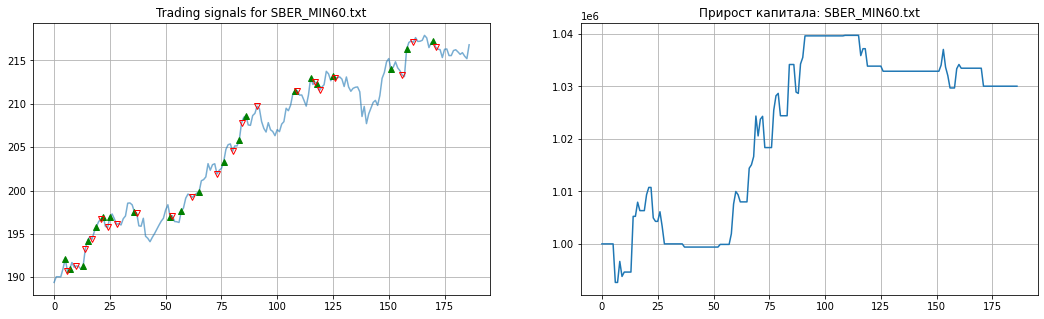


 ------------------------------------------------------------------------------------------ 

SBER_MIN60.txt
153547_t14_e30_SBER_Conv_1h_Up_v1.h5 	Прибыль:  186    26438.33
Name: capital, dtype: float64 		Доходность: 186    0.026438
Name: capital, dtype: float64 		Купи и держи: 186    0.14472
Name: close, dtype: float64


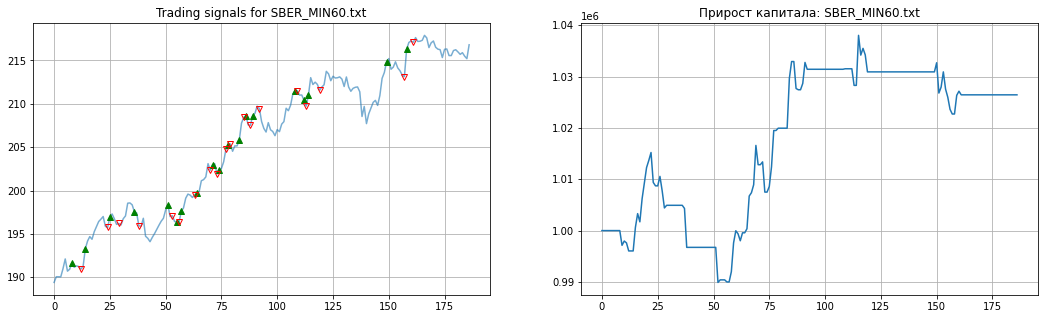


 ------------------------------------------------------------------------------------------ 

SBER_MIN60.txt
145832_t14_e31_SBER_GRU_1h_Up_v1.h5 	Прибыль:  186    105151.97
Name: capital, dtype: float64 		Доходность: 186    0.105152
Name: capital, dtype: float64 		Купи и держи: 186    0.14472
Name: close, dtype: float64


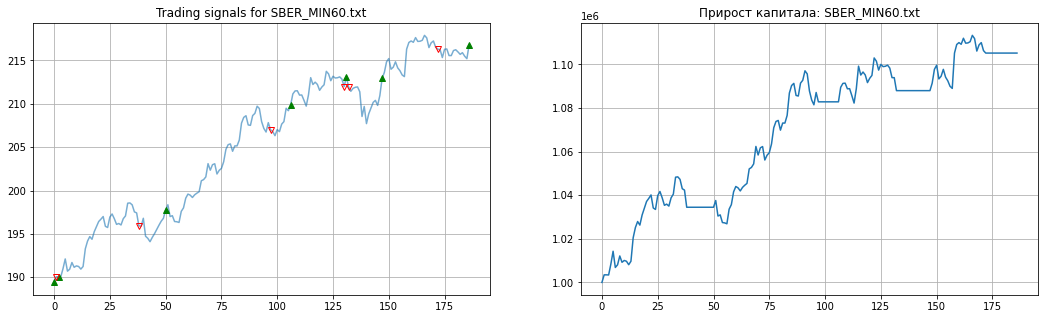


 ------------------------------------------------------------------------------------------ 

SBER_MIN60.txt
150540_t14_e29_SBER_Conv_1h_Up_v1.h5 	Прибыль:  186    47082.5
Name: capital, dtype: float64 		Доходность: 186    0.047082
Name: capital, dtype: float64 		Купи и держи: 186    0.14472
Name: close, dtype: float64


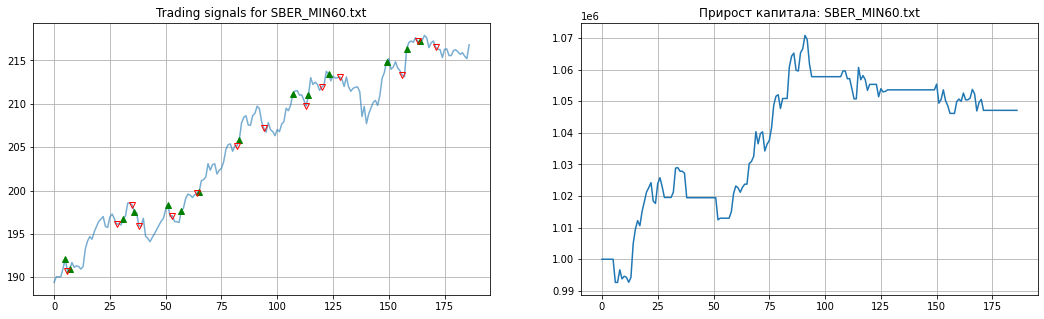


 ------------------------------------------------------------------------------------------ 

SBER_MIN60.txt
152070_t14_e28_SBER_Conv_1h_Up_v1.h5 	Прибыль:  186    26361.38
Name: capital, dtype: float64 		Доходность: 186    0.026361
Name: capital, dtype: float64 		Купи и держи: 186    0.14472
Name: close, dtype: float64


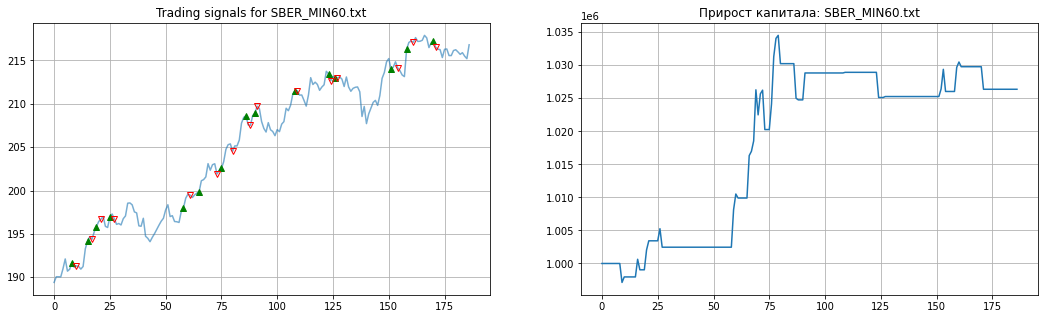


 ------------------------------------------------------------------------------------------ 

SBER_MIN60.txt
149253_t14_e27_SBER_Dense_1h_Up_v1.h5 	Прибыль:  186    69914.11
Name: capital, dtype: float64 		Доходность: 186    0.069914
Name: capital, dtype: float64 		Купи и держи: 186    0.14472
Name: close, dtype: float64


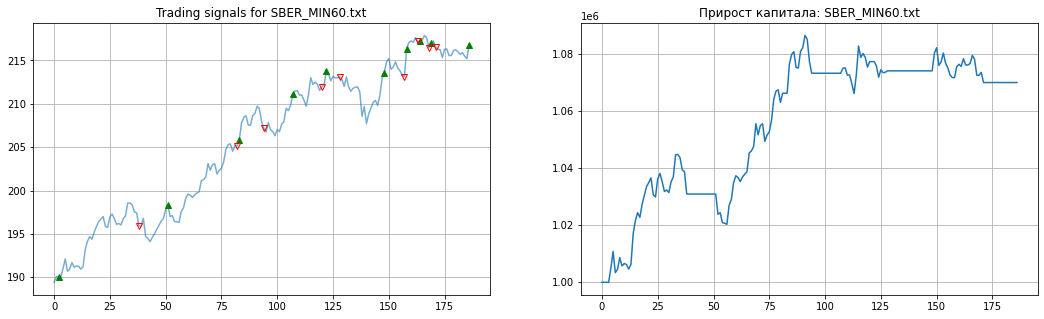


 ------------------------------------------------------------------------------------------ 

SBER_MIN60.txt
151543_t14_e30_SBER_GRU_1h_Up_v1.h5 	Прибыль:  186    95876.37
Name: capital, dtype: float64 		Доходность: 186    0.095876
Name: capital, dtype: float64 		Купи и держи: 186    0.14472
Name: close, dtype: float64


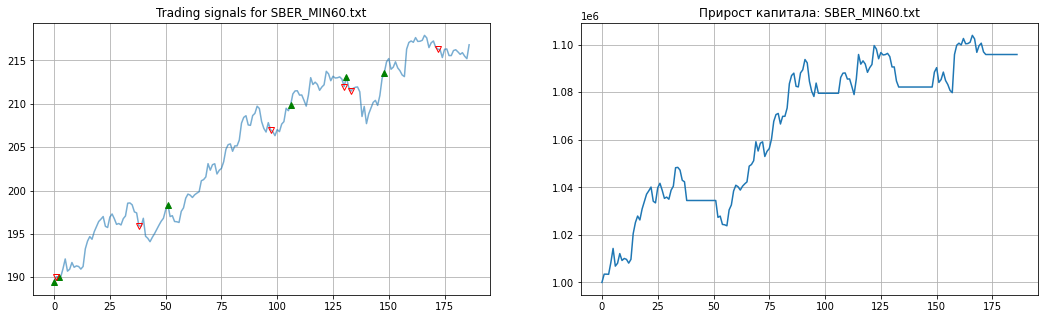


 ------------------------------------------------------------------------------------------ 

SBER_MIN60.txt
151543_t14_e28_SBER_GRU_1h_Up_v1.h5 	Прибыль:  186    102596.36
Name: capital, dtype: float64 		Доходность: 186    0.102596
Name: capital, dtype: float64 		Купи и держи: 186    0.14472
Name: close, dtype: float64


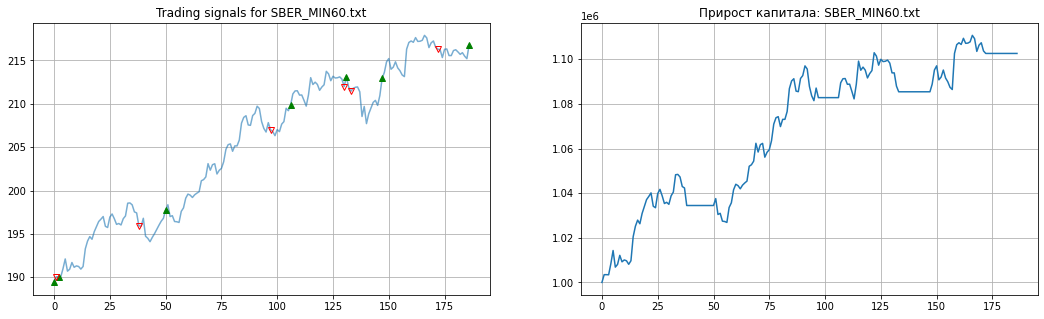


 ------------------------------------------------------------------------------------------ 

SBER_MIN60.txt
151543_t14_e29_SBER_GRU_1h_Up_v1.h5 	Прибыль:  186    102596.36
Name: capital, dtype: float64 		Доходность: 186    0.102596
Name: capital, dtype: float64 		Купи и держи: 186    0.14472
Name: close, dtype: float64


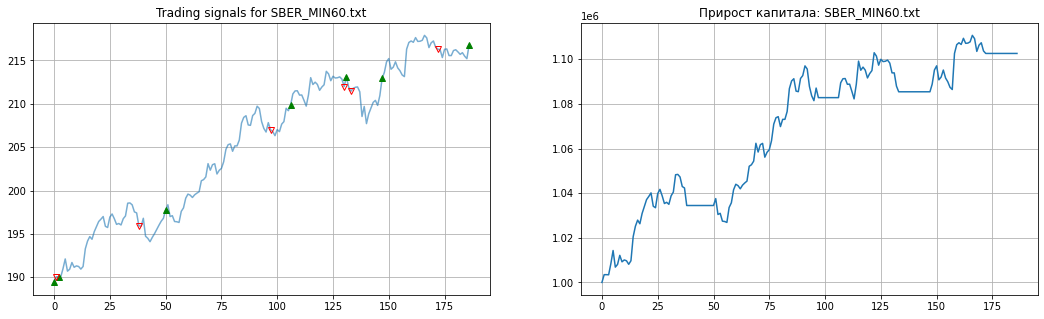


 ------------------------------------------------------------------------------------------ 



In [ ]:

for model_name in models_list:
#for model_name in ['153547_t14_e30_SBER_Conv_1h_Up_v1.h5', '151543_t14_e28_SBER_GRU_1h_Up_v1.h5']:
  # Загружаем модель и расшифровываем настройки ансамблей
  trend = int(model_name[8:10])
  ensemble = int(model_name[12:14])
  #trend = 14
  #ensemble = 19

  # Загрузка только [Open, High, Low, Close]
  os.chdir(path_tickers)
  data = pd.read_csv(ticker, sep="\t", header=None)
  print(ticker)
  data.columns=['Date', 'Open', 'High', 'Low', 'Close']

  # Применяем маску с датой
  mask = (data['Date'] >= '2019-01-01 01:00:00.000') & (data['Date'] <= '2019-12-31 23:59:59.999') # ключевая строка для форвадного анализа
  data = data[ (min(data[mask].index) - ensemble) : max(data[mask].index) ][:(200 + ensemble)]                          # весь год или только первые 200 бвров?
  #data = data[ (min(data[mask].index) - ensemble) : max(data[mask].index) ]

  df_date = data['Date'] # Оставляем дату, чтобы потом добавить в outputs
  del data['Date']
  # сдвинем все индикаторы  с шагом с 1 до step_in_the_last баров назад
  # как будто они были рассчитаны lag шагов назад
  for i in range(1, trend + 1):
    indicator_name = 'Close_chng_%d' % (i)
    data[indicator_name] = data['Close'].pct_change(i) # относительная доходность единицах
  data = data.dropna() # удаляем строки с NaN

  # Добавил разметку как в Y но сдвинул на тренд
  for i in range(1, trend + 1):
    indicator_name = 'Close_chng_%d' % (i)
    indicator_name_new = 'Y_%d' % (i)
    data[indicator_name_new] = 0
    #data.loc[data[indicator_name] < 0, indicator_name_new] = -1
    data.loc[data[indicator_name] > 0, indicator_name_new] = 1
# ----- эксперимент (оставил только цену и ohe)
  for i in range(1, trend + 1):
    indicator_name = 'Close_chng_%d' % (i)
    del data[indicator_name]
  del data['Open'], data['High'], data['Low']
# ----- конец эксперимента
  #data = data.values
  xTrain = data.values

  """ 
  # Масштабируем только X
  """
  xScaler = RobustScaler()
  xScaler.fit(xTrain)
  xTrain = xScaler.transform(xTrain)

  # Формируем выборки для обучения нейросети
  xTrain = split_sequence(xTrain, ensemble)

# ---------------------------------------------------------------------------

  os.chdir(path_models)
  model = load_model(model_name)

  os.chdir(path_outputs_val)
  returns = trading(model, xTrain)
  print(model_name, '\tПрибыль: ', returns['capital'][-1:] - 1000000,
        '\t\tДоходность:', (returns['capital'][-1:] - returns['capital'][0])/returns['capital'][0],
        '\t\tКупи и держи:', (returns['close'][-1:] - returns['close'][0])/returns['close'][0],
        )
  plotting(returns) #график торговли
  #print('\n', '-'*30)

  # запись в файл
  df_output = returns[['close', 'stock']]
  df_date = df_date[(df_date.shape[0] - df_output.shape[0]):].reset_index(drop=True) # Отрезали лишнее в датах для слияния с df_output
  df_output = pd.concat([df_date, df_output],axis=1).set_index('Date')
  df_output['order'] = df_output['stock'].diff()
  df_output['order'][0] = df_output['stock'][0]
  del df_output['stock']

  df_output.to_csv('Val_' + model_name[:-3] + '.txt', sep='\t')
  print('\n', '-'*90, '\n')
  


### Журнал торговли

In [ ]:
# Убедимся, что модель торгует с 1 января 2019 года , а не раньше
print('Журнал торговли:')
df_output[:-10]

Журнал торговли:


,close,order
Date,,
2019-01-04 14:00:00.000,189.40,5279.0
2019-01-04 15:00:00.000,190.06,-5279.0
2019-01-04 16:00:00.000,190.06,5279.0
2019-01-04 17:00:00.000,190.05,0.0
2019-01-04 18:00:00.000,190.99,0.0
...,...,...
2019-02-01 15:00:00.000,216.31,-5097.0
2019-02-01 16:00:00.000,216.25,0.0
2019-02-01 17:00:00.000,215.34,0.0
